In [1]:
import copy
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.nn import FFNN

In [2]:
DATA = '../daily/data'
N_MODS = 3

Mutate: False


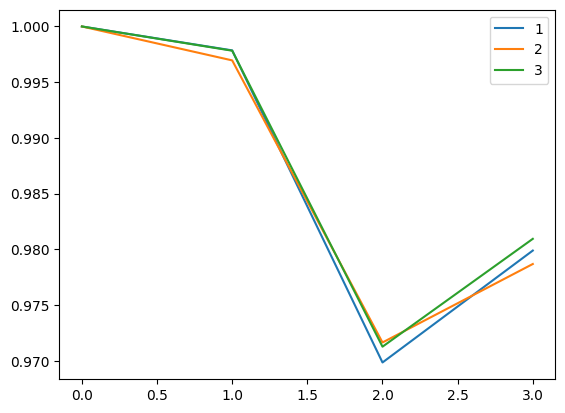

In [3]:
N_NEEDED = 8

perf1 = np.array([ 96976, 96768, 94052, 95026])
perf2 = np.array([ 96274, 95981, 93544, 94222])
perf3 = np.array([ 96609, 96399, 93833, 94768])

MUTATE = len(perf1) - 1 >= N_NEEDED
print('Mutate:', MUTATE)

buying_power = [ 33796, 40236, 43500]

plt.plot(perf1 / perf1[0], label='1')
plt.plot(perf2 / perf2[0], label='2')
plt.plot(perf3 / perf3[0], label='3')
plt.legend();

In [4]:
BEST = 3  # [1, 2, 3]
MUTATE_SCALE = 0.4455  # x0.9 or x1.1 decrease if same; incr if new

In [5]:
metrics = pd.read_csv(f'{DATA}/stock_metrics.csv')
metrics.head()

,stock,price,direction,RSI,RSIRev,fair_value_mult,geomean,sharpe
0,AAON,82.459999,1,0.402878,0.597122,0.693959,0.027174,0.649977
1,AAPL,196.979996,0,0.218625,0.781375,0.321145,0.091555,0.807898
2,ABNB,112.699997,0,0.212234,0.787766,0.285453,0.145511,0.129233
3,ACN,282.350006,0,0.061551,0.938449,0.052464,0.011288,0.627891
4,ADBE,348.799988,0,0.076739,0.923261,0.103736,0.025920,0.631462


In [6]:
x = metrics[['direction', 'RSI', 'fair_value_mult', 'geomean', 'sharpe']]

In [7]:
states = [None] * N_MODS
try:
    with open(f'{DATA}/ffnn_states.pkl', 'rb') as f:
        states = pickle.load(f)
        print('States recovered')
except FileNotFoundError:
    print('Creating new states...')
    states = [None] * N_MODS

States recovered


In [8]:
len(states)

3

In [9]:
mods = []
for state in states:
    mod = FFNN(**state) if state is not None else FFNN(5, [5])
    mods.append(mod)

In [10]:
if MUTATE:
    print('mutating...')
    best_state = mods[BEST - 1].get_state()
    mods = [mods[BEST - 1]]

    for _ in range(1, N_MODS):
        new_mod = FFNN(**copy.deepcopy(best_state))
        new_mod.mutate(scale=MUTATE_SCALE)
        mods.append(new_mod)
else:
    print('do nothing')

do nothing


In [11]:
len(mods)

3

In [12]:
#for mod in mods:
#    print(mod.Ws)

In [13]:
def get_holdings(filename, i):
    df = pd.read_csv(f'~/Downloads/ffnn/{filename}')
    df = df[['Symbol', 'Value']]
    df.Value = df.Value.str.replace('$', '').str.replace(',', '').astype(float)
    df.columns = ['stock', f'holdings{i + 1}']
    df.set_index('stock', drop=True, inplace=True)
    return df

In [14]:
holdings_files = sorted([f for f in os.listdir('/Users/damiansp/Downloads/ffnn') if f.endswith('.csv')])
holdings = pd.concat([get_holdings(f, i) for i, f in enumerate(holdings_files)], axis=1)
holdings.fillna(0, inplace=True)
holdings.head()

,holdings1,holdings2,holdings3
stock,,,
AAON,907.06,989.52,907.06
AAPL,787.74,590.81,787.74
ABBV,519.00,519.00,692.00
ABT,523.92,0.00,0.00
ACN,847.05,847.05,847.05


In [15]:
out = pd.DataFrame({'stock': metrics.stock, 'price': metrics.price.round(2)})
cols = []
for i, mod in enumerate(mods):
    value = mod.forward_pass(x, 'relu', 'sigmoid')
    value = value.squeeze()
    value /= np.sum(value)
    col = pd.Series(value, name=f'val{i + 1}')
    cols.append(col)
out = pd.concat([out, *cols], axis=1)
out.head()

,stock,price,val1,val2,val3
0,AAON,82.46,0.005683,0.006018,0.005399
1,AAPL,196.98,0.006674,0.006098,0.006648
2,ABNB,112.70,0.006037,0.006059,0.005471
3,ACN,282.35,0.006697,0.006110,0.006642
4,ADBE,348.80,0.006687,0.006107,0.006641


In [16]:
for h in [1, 2, 3]:
    invested_amt = holdings[f'holdings{h}'].sum()
    buying_power[h - 1] += invested_amt
print(buying_power)
amt_in = []
for i, d in enumerate(buying_power):
    amt = (d * out[f'val{i + 1}']).round(2)
    amt_in.append(pd.Series(amt, name=f'amt{i + 1}'))
out = pd.concat([out, *amt_in], axis=1)
out.set_index('stock', inplace=True, drop=True)
out.head()

[190052.7, 188438.41, 189536.96000000002]


,price,val1,val2,val3,amt1,amt2,amt3
stock,,,,,,,
AAON,82.46,0.005683,0.006018,0.005399,1080.05,1134.10,1023.29
AAPL,196.98,0.006674,0.006098,0.006648,1268.49,1149.11,1259.96
ABNB,112.70,0.006037,0.006059,0.005471,1147.28,1141.67,1036.93
ACN,282.35,0.006697,0.006110,0.006642,1272.85,1151.38,1258.89
ADBE,348.80,0.006687,0.006107,0.006641,1270.93,1150.87,1258.78


In [17]:
out = pd.concat([out, holdings], axis=1)
out.fillna(0, inplace=True)
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3
stock,,,,,,,,,,
AAON,82.46,0.005683,0.006018,0.005399,1080.05,1134.10,1023.29,907.06,989.52,907.06
AAPL,196.98,0.006674,0.006098,0.006648,1268.49,1149.11,1259.96,787.74,590.81,787.74
ABNB,112.70,0.006037,0.006059,0.005471,1147.28,1141.67,1036.93,0.00,0.00,0.00
ACN,282.35,0.006697,0.006110,0.006642,1272.85,1151.38,1258.89,847.05,847.05,847.05
ADBE,348.80,0.006687,0.006107,0.006641,1270.93,1150.87,1258.78,1046.40,348.80,1046.40


In [18]:
for i in range(N_MODS):
    out[f'diff{i + 1}'] = out[f'amt{i + 1}'] - out[f'holdings{i + 1}']
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3
stock,,,,,,,,,,,,,
AAON,82.46,0.005683,0.006018,0.005399,1080.05,1134.10,1023.29,907.06,989.52,907.06,172.99,144.58,116.23
AAPL,196.98,0.006674,0.006098,0.006648,1268.49,1149.11,1259.96,787.74,590.81,787.74,480.75,558.30,472.22
ABNB,112.70,0.006037,0.006059,0.005471,1147.28,1141.67,1036.93,0.00,0.00,0.00,1147.28,1141.67,1036.93
ACN,282.35,0.006697,0.006110,0.006642,1272.85,1151.38,1258.89,847.05,847.05,847.05,425.80,304.33,411.84
ADBE,348.80,0.006687,0.006107,0.006641,1270.93,1150.87,1258.78,1046.40,348.80,1046.40,224.53,802.07,212.38


In [19]:
out = out[((out.price.notnull()) & (out.price > 0))]

In [20]:
for i in range(N_MODS):
    out[f'shares{i + 1}'] = (out[f'diff{i + 1}'] / out.price).round().astype('Int64')
out = out[out.price >= 2]
out

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3,shares1,shares2,shares3
stock,,,,,,,,,,,,,,,,
AAON,82.46,0.005683,0.006018,0.005399,1080.05,1134.10,1023.29,907.06,989.52,907.06,172.99,144.58,116.23,2,2,1
AAPL,196.98,0.006674,0.006098,0.006648,1268.49,1149.11,1259.96,787.74,590.81,787.74,480.75,558.30,472.22,2,3,2
ABNB,112.70,0.006037,0.006059,0.005471,1147.28,1141.67,1036.93,0.00,0.00,0.00,1147.28,1141.67,1036.93,10,10,9
ACN,282.35,0.006697,0.006110,0.006642,1272.85,1151.38,1258.89,847.05,847.05,847.05,425.80,304.33,411.84,2,1,1
ADBE,348.80,0.006687,0.006107,0.006641,1270.93,1150.87,1258.78,1046.40,348.80,1046.40,224.53,802.07,212.38,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VTRS,7.56,0.004813,0.006073,0.003006,914.65,1144.32,569.72,0.00,1164.24,0.00,914.65,-19.92,569.72,121,-3,75
WING,218.84,0.006695,0.006110,0.006667,1272.48,1151.28,1263.64,875.36,875.36,875.36,397.12,275.92,388.28,2,1,2
WIT,2.70,0.006478,0.006097,0.006111,1231.21,1148.94,1158.27,0.00,0.00,0.00,1231.21,1148.94,1158.27,456,426,429


<span style="color: red">CHECK URL!</span>

In [21]:
o = out.sort_values('diff1', ascending=False)[['price', 'diff1', 'shares1']]
o[o.shares1 != 0].head(5)

,price,diff1,shares1
stock,,,
TPX,57.83,1258.17,22
DOCS,53.21,1250.51,24
WIT,2.70,1231.21,456
KD,29.22,1210.14,41
PTON,5.39,1196.00,222


In [22]:
o[o.shares1 != 0].tail(5)

,price,diff1,shares1
stock,,,
KR,71.22,-62.24,-1
NLR,74.82,-67.37,-1
IEFA,75.36,-128.65,-2
AEO,10.74,-172.99,-16
CCI,103.59,-177.46,-2


<span style="color: red">SERIOUSLY....</span></br>
<span style="color: red">CHECK URL!</span>

In [23]:
o = out.sort_values('diff2', ascending=False)[['price', 'diff2', 'shares2']]
o[o.shares2 != 0].head(5)

,price,diff2,shares2
stock,,,
WIT,2.70,1148.94,426
DOCS,53.21,1148.47,22
TPX,57.83,1148.07,20
PTON,5.39,1145.67,213
BIDU,82.59,1143.48,14


In [25]:
o[o.shares2 != 0].tail(5)

,price,diff2,shares2
stock,,,
NTDOY,18.06,14.26,1
VTRS,7.56,-19.92,-3
NXE,4.74,-26.17,-6
FBIN,51.47,-35.05,-1
AEO,10.74,-77.30,-7


In [26]:
o = out.sort_values('diff3', ascending=False)[['price', 'diff3', 'shares3']]
o[o.shares3 != 0].head(5)

,price,diff3,shares3
stock,,,
TPX,57.83,1255.79,22
DOCS,53.21,1242.01,23
WIT,2.70,1158.27,429
RBLX,59.71,1121.23,19
EQT,50.98,1113.17,22


In [28]:
o[o.shares3 != 0].tail(5)

,price,diff3,shares3
stock,,,
HDB,72.04,-40.76,-1
BBY,61.97,-45.00,-1
IEFA,75.36,-46.02,-1
FBIN,51.47,-49.48,-1
IBN,33.22,-75.93,-2


In [29]:
if MUTATE:
    states = [mod.get_state() for mod in mods]
    with open(f'{DATA}/ffnn_states.pkl', 'wb') as f:
        pickle.dump(states, f)
    print('States saved')
else:
    print('Did nothing')

Did nothing
